<a href="https://colab.research.google.com/github/elbixos/M2_Connectionnisme/blob/master/DeepMim/Cours/DeepMim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Commencons par charger nos données

In [4]:

import pandas as pd
from tensorflow import keras

dataset_path = keras.utils.get_file("evalMim.csv", "https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/evalMim.csv")


column_names = ['line1','line2','line3','line4','eval']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,line1,line2,line3,line4,eval
138,7,5,1,1,1
139,7,5,2,0,-1
140,7,5,2,1,1
141,7,5,3,0,1
142,7,5,3,1,-1


Puis, on sépare le label (eval) des caractéristiques

In [0]:


train_labels = dataset.pop('eval')
dataset.tail()


On peut aussi voir les labels

In [0]:
print(dataset.shape)

In [20]:

train_labels.tail()


138    1
139   -1
140    1
141    1
142   -1
Name: eval, dtype: int64

On peut maintenant construire le modele. Pour des raisons pratiques, je l'ai placé dans un fichier spécifique que nous allons récupérer.

Je vous l'affiche mais vous ne pouvez pas le modifier aussi facilement que le reste. Pour l'editer, il faudra utiliser le **volet** de gauche qui vous donne accès aux fichiers téléhargés.


In [8]:
!wget --no-http-keep-alive https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/mymodel.py
!cat mymodel.py

--2019-11-15 23:49:24--  https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/mymodel.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538 [text/plain]
Saving to: ‘mymodel.py.1’

mymodel.py.1        100%[===================>]     538  --.-KB/s    in 0s      

2019-11-15 23:49:24 (106 MB/s) - ‘mymodel.py.1’ saved [538/538]

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

def build_model():
    model = keras.Sequential([
      layers.Dense(32, activation='relu', input_shape=[4,]),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    m

In [9]:
import mymodel 
model = mymodel.build_model()
model

Et regarder sa tete...

In [10]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


Essayons quelques prédictions

In [21]:
example_batch = dataset[:5]
example_batch

,line1,line2,line3,line4
0,0,0,0,0
1,1,0,0,0
2,1,1,0,0
3,2,0,0,0
4,2,1,0,0


In [22]:
example_result = model.predict(example_batch)
example_result

array([[ 1.0242586 ],
       [-0.1373463 ],
       [ 1.1181037 ],
       [ 0.36694744],
       [ 0.93225   ]], dtype=float32)

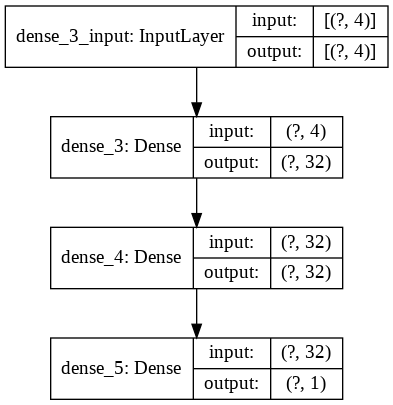

In [23]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)


Commencons l'entrainement

In [24]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Voyons ce qui s'est passé

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.178595,0.290429,0.178595,1.242240,0.868505,1.242240,995
996,0.223950,0.355108,0.223950,1.075784,0.828837,1.075784,996
997,0.192395,0.319118,0.192395,1.025046,0.801351,1.025046,997
998,0.183066,0.299883,0.183066,1.013577,0.827974,1.013577,998
999,0.166445,0.282961,0.166445,1.010541,0.821138,1.010541,999


Avec une courbe

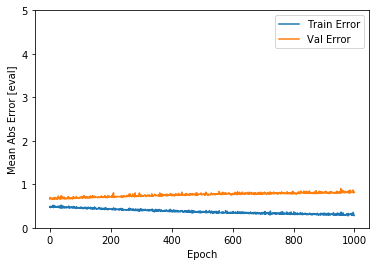

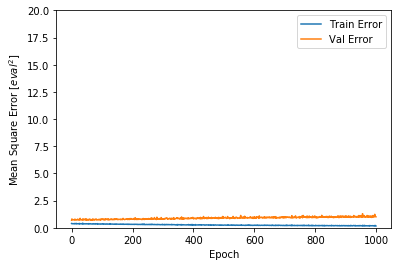

In [28]:
import matplotlib.pyplot as plt


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [eval]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$eval^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


Revoyons ce qui se passe maintenant en prédiction

In [29]:
example_batch = dataset[:5]
example_result = model.predict(example_batch)
example_result


array([[ 0.9681268 ],
       [-1.0050243 ],
       [ 0.86987066],
       [ 0.8192281 ],
       [ 0.8963525 ]], dtype=float32)

Et on attendait

In [30]:

examples_labels = train_labels[:5]
examples_labels

0    1
1   -1
2    1
3    1
4    1
Name: eval, dtype: int64

Ca semble pas mal !

Essayons de sauver le model pendant l'apprentissage

In [35]:
import os
import tensorflow as tf

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
nSamples = dataset.shape[0]
print(nSamples)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq = nSamples*100,
                                                 verbose=1)



# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 2000

history = model.fit(
  dataset, train_labels,
  epochs=EPOCHS,  verbose=0, shuffle=True,
  callbacks=[PrintDot(),cp_callback])


143

...................................................................................................
Epoch 00100: saving model to training_1/cp.ckpt
.
...................................................................................................
Epoch 00200: saving model to training_1/cp.ckpt
.
...................................................................................................
Epoch 00300: saving model to training_1/cp.ckpt
.
...................................................................................................
Epoch 00400: saving model to training_1/cp.ckpt
.
...................................................................................................
Epoch 00500: saving model to training_1/cp.ckpt
.
...................................................................................................
Epoch 00600: saving model to training_1/cp.ckpt
.
...............................................................................................

Pour charger ce model, on ferait

In [36]:
# Create a basic model instance
model2 = mymodel.build_model()

# Loads the weights
model2.load_weights(checkpoint_path)

Testons ce modele :

In [37]:
example_batch = dataset[:5]
example_result = model.predict(example_batch)
example_result


array([[ 1.0043095 ],
       [-0.96870315],
       [ 1.0782751 ],
       [ 1.0087711 ],
       [ 1.186312  ]], dtype=float32)

pour un résultat attendu de :

In [0]:

examples_labels = train_labels[:5]
examples_labels

On aurait aussi pu faire...

In [0]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model3 = build_model()

# Restore the weights
model3.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss,mae,mse= model3.evaluate(dataset,  train_labels, verbose=2)
print(loss)


Voyons une utilisation en prédiction telle qu'elle serait faite dans le jeu...


In [0]:
import numpy as np

board=[7,5,3,1]
npboard = np.asarray([board])
print(npboard.shape)
model2.predict(npboard)

Evaluons la qualité de notre apprentissage

In [38]:
!wget https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/testLearningEvaluation.py
!python testLearningEvaluation.py

--2019-11-15 23:55:17--  https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/testLearningEvaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201 (1.2K) [text/plain]
Saving to: ‘testLearningEvaluation.py’

testLearningEvaluat 100%[===================>]   1.17K  --.-KB/s    in 0s      

2019-11-15 23:55:18 (223 MB/s) - ‘testLearningEvaluation.py’ saved [1201/1201]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2019-11-15 23:55:22.603452: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-11-15 23:55:22.603727: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2cd1800 initialized for platform Host (this does not guarantee that XLA will

In [0]:
def computeErrors(x,labels, predictions):
  truths = labels.values
  nbErrors=0
  for i in range(len(truths)) :
    if truths[i]*predictions[i][0] <=0 :
      nbErrors += 1
      print(i,x.iloc[i,0],x.iloc[i,1],x.iloc[i,2],x.iloc[i,3],truths[i],predictions[i][0])
  return nbErrors

pred = model2.predict(dataset)

computeErrors(dataset,train_labels,pred)

Incrustons tout ceci dans un jeu d'allumettes

In [42]:
!wget https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/player.py

--2019-11-16 00:01:12--  https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/player.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5860 (5.7K) [text/plain]
Saving to: ‘player.py’

player.py           100%[===================>]   5.72K  --.-KB/s    in 0s      

2019-11-16 00:01:12 (87.3 MB/s) - ‘player.py’ saved [5860/5860]



Et on va pouvoir tester

In [44]:

import player

import random

def displayBoard(board) :
        """
        display the board
        """
        for i in range(len(board)) :
            print(i ,":  ", end="")
            for j in range(board[i]) :
                print("I", end = "")
            print("")


def drawMatches (line, nbMatches,board):
    """
    Draw some matches on the current board.

    It check if the proposal is valid.
    """
    if (isValidStrategy(line, nbMatches,board)) :
        board[line]-=nbMatches
    else :
        print ("You tried something bad")

def isFinished (board):
    """
    Tell if the game is finished or not
    (finished if no matches remains)
    """
    if countMatches(board) == 0:
        return True
    return False


def countMatches (board):
    """
    Count matches on the board
    """

    nbAll =0
    for ligne in board:
        if ligne >= 0:
            nbAll+=ligne
    return nbAll

def isValidStrategy (line, nbMatches, board):
    """
    test if a strategy is valid for the current state of the Board

    One could ask if a strategy is valid for a different board. If so,
    pass the board as a parameter
    """
    if (line < 0 or line >=4):
        return False

    if nbMatches < 1 or nbMatches >3 :
        return False

    if board[line]-nbMatches < 0:
        return False

    return True

def changePlayer(numJoueur):
    numJoueur = (numJoueur+1)%2
    return numJoueur


victories=0
nbGames = 1

p1=player.IADeepPlayer()
p2=player.IARandomPlayer()


for i in range(nbGames):

    board = [7 , 5, 3, 1]
    numJoueur = 0

    #print ("avec ",board ,"j'aurais ce resultat", evaluate(board,False,0))
    #print ("avec ",board ,"je joue ", IAMakeChoice(board))



    draw = random.random()
    if draw <0.5:
        players=[p1,p2]
        IA=0
    else :
        players=[p2,p1]
        IA=1


    while(not isFinished(board)):
            line, nbMatches = players[numJoueur].makeChoice(board)
            drawMatches(line, nbMatches,board)
            numJoueur = changePlayer(numJoueur)

    if numJoueur == IA:
        victories+=1

print ("IA wins in ",victories, "over ",nbGames)


AttributeError: ignored